In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
import json
from collections import defaultdict, Counter
from datetime import datetime

import numpy as np
import pandas as pd
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities

###############################################################################
# הגדרות
###############################################################################
YEARS = list(range(2018, 2026))  # 2018–2025 כולל
INPUT_FOLDER_TEMPLATE = "articles_{year}_new"      # בכל שנה: articles_{year}_new
INPUT_FILE_NAME = "all_articles_enhanced.jsonl"    # הקובץ בכל שנה
OUTPUT_ROOT = "bridge_emergence_B"

# סף מזערי לסינון מחברים "ריקים" באותה שנה (למשל דרגת קשר > 0)
MIN_DEGREE_PER_YEAR = 1

# אם יש שנים ענקיות, ניתן להגביל לפי מינימום הופעות במחקרים בשנה
MIN_PAPERS_PER_AUTHOR_PER_YEAR = 1  # 1 משמע ללא סינון נוסף

###############################################################################
# קריאת נתונים
###############################################################################
def read_year_items(year):
    folder = INPUT_FOLDER_TEMPLATE.format(year=year)
    path = os.path.join(folder, INPUT_FILE_NAME)
    if not os.path.exists(path):
        print(f"⚠ File not found for year {year}: {path}")
        return []

    items = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                obj = json.loads(line)
                items.append(obj)
            except Exception:
                continue
    return items


def extract_authors_from_item(item):
    """מחזיר רשימת מזהי מחברים (author_id) מתוך פריט מאמר."""
    authors = []
    for a in item.get("authors", []) or []:
        aid = a.get("author_id")
        if aid:
            authors.append(aid)
    # מסיר כפילויות באותו מאמר
    authors = list(dict.fromkeys(authors))
    return authors


###############################################################################
# בניית גרף מחברים לכל שנה
###############################################################################
def build_coauthor_graph(year_items):
    """
    בונה גרף מחברים–מחברים לאותה שנה.
    צומת = מחבר; קשת משוקללת = #מאמרים משותפים.
    מחזיר:
      G: nx.Graph עם משקל 'weight' על קשתות
      author_paper_count: כמה מאמרים היה לכל מחבר בשנה
    """
    G = nx.Graph()
    author_paper_count = Counter()

    for it in year_items:
        authors = extract_authors_from_item(it)
        if not authors or len(authors) == 1:
            # גם יחיד: נרשום קיום מחבר במערכת, כדי לא לאבדו
            for a in authors:
                author_paper_count[a] += 1
                if a not in G:
                    G.add_node(a)
            continue

        # עדכון ספירת מאמרים פר מחבר
        for a in authors:
            author_paper_count[a] += 1
            if a not in G:
                G.add_node(a)

        # קשתות בין כל הזוגות (co-authorship); משקל = מספר מאמרים משותפים
        for i in range(len(authors)):
            for j in range(i + 1, len(authors)):
                u, v = authors[i], authors[j]
                if G.has_edge(u, v):
                    G[u][v]['weight'] += 1
                else:
                    G.add_edge(u, v, weight=1)

    return G, author_paper_count


###############################################################################
# Participation Coefficient לכל מחבר
###############################################################################
def participation_coefficient(G, communities):
    """
    מחשב Participation Coefficient לכל מחבר לפי חלוקת קהילות נתונה.
    communities: Iterable של סטים (כל סט = קהילה של צמתים)
    מחזיר dict: author_id -> P in [0,1], ו-dict של מיפוי מחבר->שם קהילה
    """
    # מפה מצומת -> מזהה קהילה
    comm_id_map = {}
    for idx, comm in enumerate(communities):
        for node in comm:
            comm_id_map[node] = idx

    P = {}
    for a in G.nodes():
        k_a = G.degree(a, weight=None)  # מספר שכנים (לא משקל האדג׳ים)
        if k_a == 0:
            P[a] = np.nan  # אין שכנים → לא מוגדר; אפשר גם 0
            continue

        # כמה שכנים לכל קהילה
        neighbor_comm_counts = Counter()
        for nb in G.neighbors(a):
            c = comm_id_map.get(nb, -1)
            neighbor_comm_counts[c] += 1

        # Participation coefficient
        s = 0.0
        for c, k_ac in neighbor_comm_counts.items():
            frac = k_ac / k_a
            s += frac * frac
        P[a] = 1.0 - s

    return P, comm_id_map


###############################################################################
# BES: הפרש P_a בין השנה הראשונה לשנה האחרונה בה המחבר עמד בסף
###############################################################################
def ensure_output_dir():
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    out_dir = f"{OUTPUT_ROOT}_{ts}"
    os.makedirs(out_dir, exist_ok=True)
    return out_dir


def main():
    out_dir = ensure_output_dir()

    # לאגירת תוצאות שנתיות
    yearly_rows = []  # per author per year participation + degree + papers
    authors_year_P = defaultdict(dict)  # author -> {year: P}
    authors_year_deg = defaultdict(dict)  # author -> {year: degree}
    authors_year_papers = defaultdict(dict)  # author -> {year: papers}

    for year in YEARS:
        print(f"➤ Processing year {year} ...")
        items = read_year_items(year)
        if not items:
            print(f"  ⚠ No data for {year}, skipping.")
            continue

        G, papers_cnt = build_coauthor_graph(items)

        # סינון מחברים שלא עומדים בסף מאמרים בשנה
        keep_nodes = {a for a, c in papers_cnt.items() if c >= MIN_PAPERS_PER_AUTHOR_PER_YEAR}
        if keep_nodes:
            G = G.subgraph(keep_nodes).copy()
            papers_cnt = Counter({a: c for a, c in papers_cnt.items() if a in keep_nodes})

        # אם הגרף ריק/דליל מאוד
        if G.number_of_nodes() == 0:
            print(f"  ⚠ Empty graph in {year}, skipping.")
            continue

        # קהילות (Greedy Modularity – מובנה ומספיק מהיר לאלפים)
        communities = list(greedy_modularity_communities(G))

        # Participation coefficient
        P_map, comm_id_map = participation_coefficient(G, communities)

        # דרגה בלתי משוקללת (מס שכנים), למעקב
        deg_map = dict(G.degree(weight=None))

        # אגירת שורה לכל מחבר בשנה
        for a in G.nodes():
            P = P_map.get(a, np.nan)
            deg = deg_map.get(a, 0)
            papers = papers_cnt.get(a, 0)

            # מסנן מחברים ללא שכנים אם לא רוצים לכלול (דרגה 0)
            if deg < MIN_DEGREE_PER_YEAR:
                # עדיין נשמור רשומת מידע, אבל לא נחשב ל-BES בהמשך (כי אין שכנים)
                pass

            yearly_rows.append({
                "year": year,
                "author_id": a,
                "degree": deg,
                "papers": papers,
                "participation": P,
                "community_id": comm_id_map.get(a, -1),
                "num_communities_year": len(communities),
                "num_nodes_year": G.number_of_nodes(),
                "num_edges_year": G.number_of_edges()
            })
            authors_year_P[a][year] = P
            authors_year_deg[a][year] = deg
            authors_year_papers[a][year] = papers

    if not yearly_rows:
        print("No yearly rows produced. Check input folders/files.")
        return

    df_yearly = pd.DataFrame(yearly_rows)
    df_yearly = df_yearly.sort_values(["author_id", "year"]).reset_index(drop=True)

    # חישוב BES לכל מחבר: P(last) - P(first) עבור שנים שבהן יש דרגה >= MIN_DEGREE_PER_YEAR ו-P לא NaN
    bes_rows = []
    for a, year_to_P in authors_year_P.items():
        # בוחרים רק שנים בהן המחבר "פעיל": דרגה >= MIN_DEGREE_PER_YEAR ו-P תקף
        valid_years = []
        for y, P in year_to_P.items():
            deg = authors_year_deg[a].get(y, 0)
            if deg >= MIN_DEGREE_PER_YEAR and P is not None and not (isinstance(P, float) and np.isnan(P)):
                valid_years.append(y)
        if len(valid_years) < 2:
            continue

        ys = sorted(valid_years)
        first_y, last_y = ys[0], ys[-1]
        P_first = year_to_P[first_y]
        P_last  = year_to_P[last_y]

        # גרף הזמן: נוכל גם לחשב שיפוע לינארי אם רוצים (אופציונלי)
        # כאן BES = דלתא פשוטה בין סוף להתחלה
        bes = float(P_last - P_first)

        # אפשר לשמור גם ממוצעים, מקסימום, #שנים וכו'
        bes_rows.append({
            "author_id": a,
            "year_first": int(first_y),
            "year_last": int(last_y),
            "P_first": float(P_first),
            "P_last": float(P_last),
            "BES_delta": bes,
            "years_active": len(ys),
            "mean_degree_active_years": float(np.mean([authors_year_deg[a][y] for y in ys])),
            "mean_papers_active_years": float(np.mean([authors_year_papers[a][y] for y in ys]))
        })

    if not bes_rows:
        print("No authors with ≥2 valid years. Consider lowering thresholds.")
        return

    df_bes = pd.DataFrame(bes_rows)
    df_bes = df_bes.sort_values("BES_delta", ascending=False).reset_index(drop=True)

    # שמירות
    per_year_path = os.path.join(out_dir, "per_year_author_participation.csv")
    bes_path = os.path.join(out_dir, "bes_summary.csv")
    top_path = os.path.join(out_dir, "top_emerging_bridges.csv")

    df_yearly.to_csv(per_year_path, index=False, encoding="utf-8")
    df_bes.to_csv(bes_path, index=False, encoding="utf-8")
    # Top emerging bridges (לפי BES_delta)
    df_bes.head(1000).to_csv(top_path, index=False, encoding="utf-8")

    # README באנגלית
    readme = f"""Bridge Emergence Score (Part B)
================================================

Goal:
-----
Compute dynamic "bridge emergence" for authors across years by measuring how their 
collaboration neighborhoods spread across communities over time.

Definitions:
------------
- For each year, we build an undirected co-authorship graph:
    Node  = author_id
    Edge  = co-authorship within that year (weight = #shared papers)
- Communities are detected via Greedy Modularity (NetworkX built-in).
- Participation Coefficient for author 'a' in year 't':
      P_a(t) = 1 - sum_c (k_a,c(t) / k_a(t))^2
  where k_a(t) is the number of neighbors of 'a' (unweighted degree),
  and k_a,c(t) is the number of 'a''s neighbors in community c for that year.

- Bridge Emergence Score (BES) for author 'a':
      BES_a = P_a(t_last) - P_a(t_first)
  computed over the subset of years where degree >= {MIN_DEGREE_PER_YEAR} and P_a(t) is defined.

Inputs:
-------
- For each year in: {INPUT_FOLDER_TEMPLATE} (e.g., articles_2018_new)
- File name: {INPUT_FILE_NAME}
- Each line is an enriched article JSON with an 'authors' list containing 'author_id'.

Outputs:
--------
- per_year_author_participation.csv
    year, author_id, degree (unweighted), papers, participation, community_id, 
    num_communities_year, num_nodes_year, num_edges_year

- bes_summary.csv
    author_id, year_first, year_last, P_first, P_last, BES_delta, 
    years_active, mean_degree_active_years, mean_papers_active_years

- top_emerging_bridges.csv
    Top authors by BES_delta (descending)

Notes:
------
- Thresholds:
    MIN_DEGREE_PER_YEAR = {MIN_DEGREE_PER_YEAR}
    MIN_PAPERS_PER_AUTHOR_PER_YEAR = {MIN_PAPERS_PER_AUTHOR_PER_YEAR}
  Tune these if your yearly graphs are too sparse/dense.

- Community detection:
    Greedy Modularity is deterministic and fast enough for graphs with thousands of nodes.
    If you prefer Leiden/Louvain, swap the detector accordingly.

- Interpretation:
    Higher BES_delta means the author evolved from a more "single-community" collaboration pattern
    to a more "multi-community" one (i.e., became more of a bridge over time).

- Suggested follow-ups:
    * Correlate BES with impact metrics (citations, citations-per-reference).
    * Test whether high-BES authors are over-represented on field pairs with high FCA (Part A).
    * Significance checks via degree-preserving randomization per year.
"""
    with open(os.path.join(out_dir, "README.txt"), "w", encoding="utf-8") as f:
        f.write(readme)

    print("\n✅ Done!")
    print(f"- Saved: {per_year_path}")
    print(f"- Saved: {bes_path}")
    print(f"- Saved: {top_path}")
    print(f"- Output folder: {out_dir}")


if __name__ == "__main__":
    main()


➤ Processing year 2018 ...
➤ Processing year 2019 ...
➤ Processing year 2020 ...
➤ Processing year 2021 ...


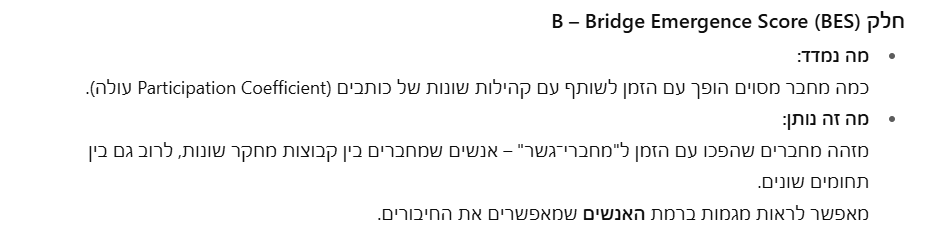

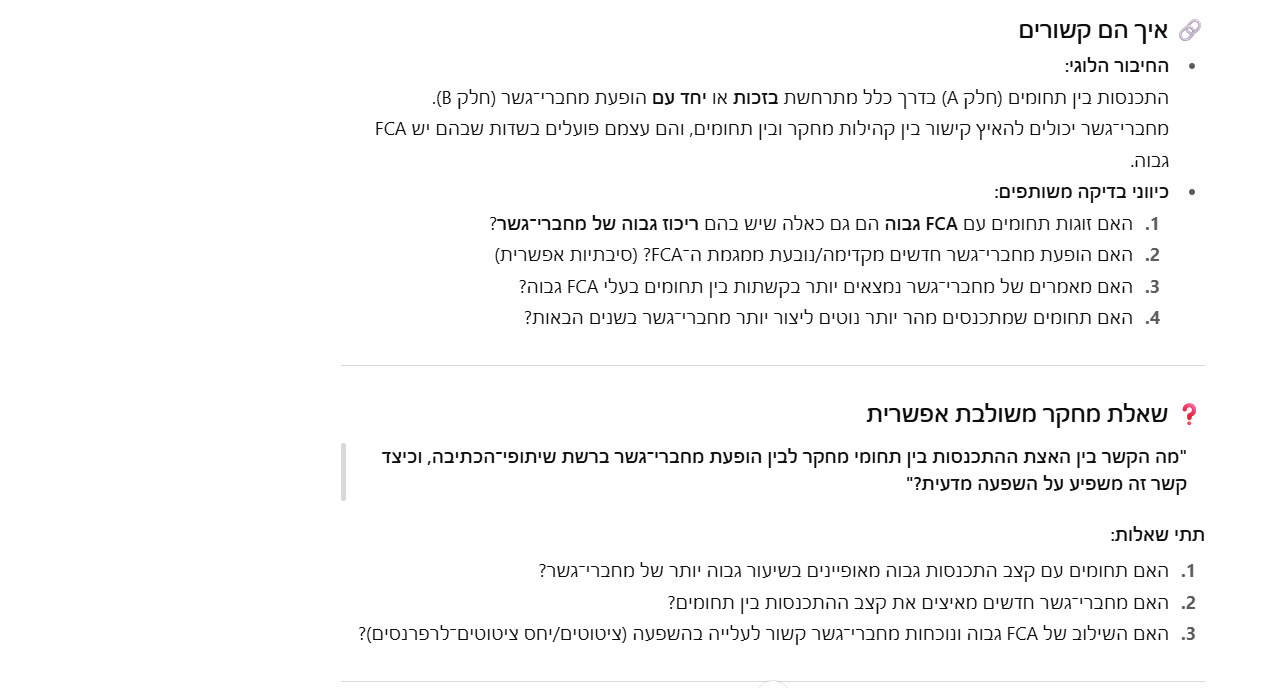

In [2]:
pip install igraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 16.2 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [igraph]2m1/2 [igraph]
Note: you may need to restart the kernel to use updated packages.


In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# Part B (FAST): Bridge Emergence Score with python-igraph + multiprocessing
# Outputs are זהים לשמות מהגרסה הקודמת:
# - per_year_author_participation.csv
# - bes_summary.csv
# - top_emerging_bridges.csv
# - README.txt

import os, json, math
from datetime import datetime
from collections import Counter, defaultdict
from multiprocessing import Pool, cpu_count

import numpy as np
import pandas as pd
import igraph as ig

# ---------------------------- Config -----------------------------
YEARS = list(range(2018, 2026))  # 2018–2025 inclusive
INPUT_FOLDER_TEMPLATE = "articles_{year}_new"
INPUT_FILE_NAME = "all_articles_enhanced.jsonl"
OUTPUT_ROOT = "bridge_emergence_B"

MIN_DEGREE_PER_YEAR = 1
MIN_PAPERS_PER_AUTHOR_PER_YEAR = 1
# ----------------------------------------------------------------

def ensure_out_dir():
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    out_dir = f"{OUTPUT_ROOT}_{ts}"
    os.makedirs(out_dir, exist_ok=True)
    return out_dir

def read_year_papers(year):
    folder = INPUT_FOLDER_TEMPLATE.format(year=year)
    path = os.path.join(folder, INPUT_FILE_NAME)
    if not os.path.exists(path):
        return []
    papers = []
    with open(path, "r", encoding="utf-8") as f:
        for ln in f:
            ln = ln.strip()
            if not ln:
                continue
            try:
                obj = json.loads(ln)
            except Exception:
                continue
            # take author ids (unique per paper)
            authors = []
            for a in obj.get("authors") or []:
                aid = a.get("author_id")
                if aid:
                    authors.append(str(aid))
            if not authors:
                continue
            authors = list(dict.fromkeys(authors))
            papers.append(authors)
    return papers

def build_graph_from_papers(papers, min_papers_per_author):
    """Build co-authorship graph for a given year's papers (list[list[author_id]])"""
    author_papers = Counter()
    for auths in papers:
        for a in auths:
            author_papers[a] += 1

    # vertices: all authors
    authors = list(author_papers.keys())
    idx_of = {a:i for i,a in enumerate(authors)}

    # edges with weights
    edge_w = Counter()
    for auths in papers:
        # (optional) keep all — נסנן צמתים אחר כך
        if len(auths) > 1:
            L = len(auths)
            for i in range(L-1):
                ai = idx_of[auths[i]]
                for j in range(i+1, L):
                    aj = idx_of[auths[j]]
                    if ai == aj:
                        continue
                    e = (ai, aj) if ai < aj else (aj, ai)
                    edge_w[e] += 1

    if not authors:
        return None, {}, {}

    G = ig.Graph()
    G.add_vertices(len(authors))
    G.vs["name"] = authors
    if edge_w:
        edges = list(edge_w.keys())
        weights = [edge_w[e] for e in edges]
        G.add_edges(edges)
        G.es["weight"] = weights

    # store per-vertex papers count
    G.vs["papers"] = [author_papers[a] for a in authors]

    # filter low-activity authors
    keep = [i for i,pc in enumerate(G.vs["papers"]) if pc >= min_papers_per_author]
    if len(keep) == 0:
        return None, {}, {}

    G = G.subgraph(keep)
    return G, author_papers, {G.vs[i]["name"]: i for i in range(G.vcount())}

def participation_coefficients(G, memberships):
    """
    P_a = 1 - sum_c (k_ac/k_a)^2 ; degree is unweighted neighbor count.
    memberships: list of community id per vertex index.
    """
    P = np.full(G.vcount(), np.nan, dtype=float)
    deg = np.array(G.degree(mode="ALL"), dtype=int)

    # neighbors per vertex
    for v in range(G.vcount()):
        k = deg[v]
        if k <= 0:
            continue
        neigh = G.neighbors(v)
        if not neigh:
            continue
        # count communities among neighbors
        counts = Counter(memberships[n] for n in neigh)
        s = 0.0
        for _, k_ac in counts.items():
            frac = k_ac / k
            s += frac * frac
        P[v] = 1.0 - s
    return P, deg

def process_one_year(year):
    """
    Returns:
      rows_year: list[dict] for per_year_author_participation
    """
    papers = read_year_papers(year)
    if not papers:
        return []

    G, papers_cnt, name_to_idx = build_graph_from_papers(papers, MIN_PAPERS_PER_AUTHOR_PER_YEAR)
    if G is None or G.vcount() == 0:
        return []

    # communities (Louvain)
    # uses edge weights if present
    try:
        vc = G.community_multilevel(weights=G.es["weight"] if "weight" in G.es.attributes() else None)
    except Exception:
        # fallback unweighted
        vc = G.community_multilevel()
    memberships = vc.membership
    num_comms = len(set(memberships))

    # participation
    P, deg = participation_coefficients(G, memberships)

    # collect rows
    rows = []
    names = G.vs["name"]
    for i, aid in enumerate(names):
        p = float(P[i]) if not (isinstance(P[i], float) and math.isnan(P[i])) else np.nan
        d = int(deg[i])
        rows.append({
            "year": year,
            "author_id": aid,
            "degree": d,
            "papers": int(G.vs[i]["papers"]) if "papers" in G.vs.attributes() else int(papers_cnt.get(aid, 0)),
            "participation": p,
            "community_id": int(memberships[i]),
            "num_communities_year": num_comms,
            "num_nodes_year": int(G.vcount()),
            "num_edges_year": int(G.ecount())
        })
    return rows

def main():
    out_dir = ensure_out_dir()

    # parallel per-year
    with Pool(processes=min(len(YEARS), max(1, cpu_count()-1))) as pool:
        results = pool.map(process_one_year, YEARS)

    # concat per-year rows
    yearly_rows = [r for lst in results for r in lst]
    if not yearly_rows:
        print("No data produced.")
        return

    df_yearly = pd.DataFrame(yearly_rows).sort_values(["author_id","year"]).reset_index(drop=True)
    per_year_path = os.path.join(out_dir, "per_year_author_participation.csv")
    df_yearly.to_csv(per_year_path, index=False, encoding="utf-8")

    # compute BES: P_last - P_first over valid years (degree>=MIN_DEGREE_PER_YEAR & finite P)
    bes_rows = []
    for aid, sub in df_yearly.groupby("author_id"):
        sub = sub[(sub["degree"] >= MIN_DEGREE_PER_YEAR) & np.isfinite(sub["participation"])].sort_values("year")
        if len(sub) < 2:
            continue
        P_first = float(sub.iloc[0]["participation"])
        P_last  = float(sub.iloc[-1]["participation"])
        bes = P_last - P_first
        bes_rows.append({
            "author_id": aid,
            "year_first": int(sub.iloc[0]["year"]),
            "year_last": int(sub.iloc[-1]["year"]),
            "P_first": P_first,
            "P_last": P_last,
            "BES_delta": float(bes),
            "years_active": int(sub["year"].nunique()),
            "mean_degree_active_years": float(sub["degree"].mean()),
            "mean_papers_active_years": float(sub["papers"].mean()),
        })

    if not bes_rows:
        print("No authors with >=2 valid years for BES.")
        return

    df_bes = pd.DataFrame(bes_rows).sort_values("BES_delta", ascending=False).reset_index(drop=True)
    bes_path = os.path.join(out_dir, "bes_summary.csv")
    top_path = os.path.join(out_dir, "top_emerging_bridges.csv")
    df_bes.to_csv(bes_path, index=False, encoding="utf-8")
    df_bes.head(1000).to_csv(top_path, index=False, encoding="utf-8")

    # README
    readme = f"""Bridge Emergence Score (FAST, igraph)
================================================

Years: 2018–2025
Inputs: {INPUT_FOLDER_TEMPLATE}/all_articles_enhanced.jsonl per year

Steps:
- Build yearly co-authorship graph in python-igraph (edge weight = #shared papers).
- Community detection: Louvain (community_multilevel).
- Participation per author P_a(t) = 1 - sum_c (k_ac/k_a)^2 (degree unweighted).
- BES_a = P_a(last) - P_a(first) over valid years (degree >= {MIN_DEGREE_PER_YEAR}).

Outputs:
- per_year_author_participation.csv
- bes_summary.csv
- top_emerging_bridges.csv

Filters:
- MIN_PAPERS_PER_AUTHOR_PER_YEAR = {MIN_PAPERS_PER_AUTHOR_PER_YEAR}
- MIN_DEGREE_PER_YEAR = {MIN_DEGREE_PER_YEAR}
"""
    with open(os.path.join(out_dir, "README.txt"), "w", encoding="utf-8") as f:
        f.write(readme)

    print("\n✅ Done (FAST B)")
    print(f"- Saved: {per_year_path}")
    print(f"- Saved: {bes_path}")
    print(f"- Saved: {top_path}")
    print(f"- Output folder: {out_dir}")

if __name__ == "__main__":
    main()



✅ Done (FAST B)
- Saved: bridge_emergence_B_20250816_123419/per_year_author_participation.csv
- Saved: bridge_emergence_B_20250816_123419/bes_summary.csv
- Saved: bridge_emergence_B_20250816_123419/top_emerging_bridges.csv
- Output folder: bridge_emergence_B_20250816_123419
